<a href="https://colab.research.google.com/github/TorresNaly/ce-bigfish/blob/main/notebooks/train_Cellpose-SAM-250723.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cellpose-SAM: superhuman generalization for cellular segmentation

Marius Pachitariu, Michael Rariden, Carsen Stringer

[paper](https://www.biorxiv.org/content/10.1101/2025.04.28.651001v1) | [code](https://github.com/MouseLand/cellpose)

This notebook shows how to process your own 2D or 3D images, saved on Google Drive.

This notebook is adapted from the notebook by Pradeep Rajasekhar, inspired by the [ZeroCostDL4Mic notebook series](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

### Make sure you have GPU access enabled by going to Runtime -> Change Runtime Type -> Hardware accelerator and selecting GPU

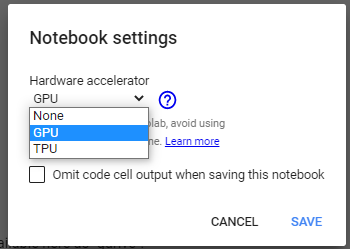

### Mount your google drive

If you have some images to train on, mount your drive. Alternatively scroll down and download the example images.

Run this cell to connect your Google Drive to colab:
* Click on the URL.
* Sign in your Google Account.

You will either have to:
* copy the authorisation code and enter it into box below OR
* in the new google colab, you can just click "Allow" and it should connect.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



Then click on "Folder" icon on the Left, press the refresh button. Your Google Drive folder should now be available here as "gdrive".


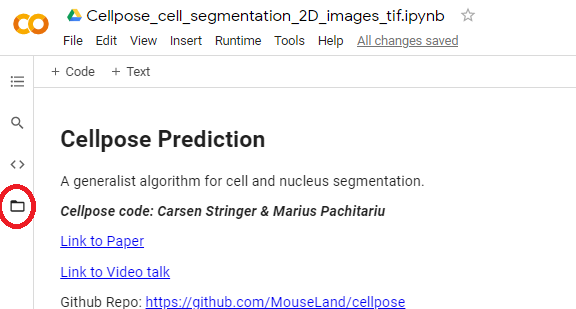

Click on the triangle icon and it will allow you to access whole drive. Navigate to the folder containing your images. Once you are there, click on the three dots on the right of the folder and select "Copy Path"

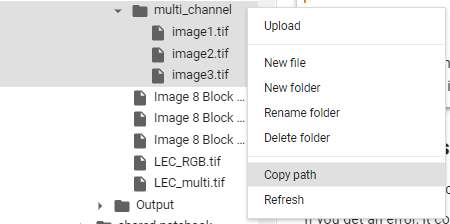

Copy and paste this path in the **dir** string below

### Install Cellpose-SAM


In [2]:
!pip install git+https://www.github.com/mouseland/cellpose.git

  Cloning https://www.github.com/mouseland/cellpose.git to /tmp/pip-req-build-smys2hqh
  Running command git clone --filter=blob:none --quiet https://www.github.com/mouseland/cellpose.git /tmp/pip-req-build-smys2hqh
  Resolved https://www.github.com/mouseland/cellpose.git to commit df6b944673c3ab6d46c2cb780bcde040970dbebc
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   

Check GPU and instantiate model - will download weights.

In [3]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.7.dev7+gdf6b944 
platform:       	linux 
python version: 	3.11.13 
torch version:  	2.6.0+cu124! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 


creating new log file
2025-07-23 21:19:36,774 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2025-07-23 21:19:36,775 [INFO] 
cellpose version: 	4.0.7.dev7+gdf6b944 
platform:       	linux 
python version: 	3.11.13 
torch version:  	2.6.0+cu124
2025-07-23 21:19:37,060 [INFO] ** TORCH CUDA version installed and working. **
2025-07-23 21:19:37,062 [INFO] ** TORCH CUDA version installed and working. **
2025-07-23 21:19:37,063 [INFO] >>>> using GPU (CUDA)
2025-07-23 21:19:39,907 [INFO] Downloading: "https://huggingface.co/mouseland/cellpose-sam/resolve/main/cpsam" to /root/.cellpose/models/cpsam



100%|██████████| 1.15G/1.15G [00:06<00:00, 187MB/s]


Input directory with your images (if you have them, otherwise use sample images):

In [91]:
# *** change to your google drive folder path ***
train_dir = "/content/drive/MyDrive/cellpose_training/train_dir"
if not Path(train_dir).exists():
  raise FileNotFoundError("directory does not exist")

test_dir = "/content/drive/MyDrive/cellpose_training/test_dir" # optionally you can specify a directory with test files

# *** change to your mask extension ***
masks_ext = "_masks.tif"
# ^ assumes images from Cellpose GUI, if labels are tiffs, then "_masks.tif"

# list all files
files = [f for f in Path(test_dir).glob("*") if "_masks" not in f.name and "_flows" not in f.name and "_seg" not in f.name]

if(len(files)==0):
  raise FileNotFoundError("no files found, did you specify the correct folder and extension?")
else:
  print(f"{len(files)} files in folder:")

for f in files:
  print(f.name)


8 files in folder:
.DS_Store
.ipynb_checkpoints
img_9.tif
img_2.tif
img_1.tif
img_29.tif
img_19.tif
img_8.tif


In [92]:
import tifffile
import numpy as np

for f in files:
    img = tifffile.imread(f)
    print(f"{f.name}: shape = {img.shape}")

TiffFileError: not a TIFF file b'\x00\x00\x00\x01'

In [41]:
from pathlib import Path
import tifffile
import numpy as np

input_dir = Path("/content/drive/MyDrive/cellpose_training/test_dir")
for f in input_dir.glob("img_*.tif"):
    img = tifffile.imread(f)
    if img.shape[0] == 1:
        img = img[0]  # remove channel axis
    tifffile.imwrite(f, img.astype(np.float32))  # overwrite or save to new dir


In [42]:
import tifffile
import numpy as np

for f in files:
    img = tifffile.imread(f)
    print(f"{f.name}: shape = {img.shape}")

img_1.tif: shape = (1024, 1024)
img_19.tif: shape = (1024, 1024)
img_2.tif: shape = (1024, 1024)
img_29.tif: shape = (1024, 1024)
img_9.tif: shape = (1024, 1024)
img_8.tif: shape = (1024, 1024)


In [49]:
for i, img in enumerate(train_data):
    print(f"Train {i}: shape={img.shape}, min={img.min()}, max={img.max()}")

for i, img in enumerate(test_data):
    print(f"Test {i}: shape={img.shape}, min={img.min()}, max={img.max()}")


Train 0: shape=(1024, 1024), min=138.0, max=2303.0
Train 1: shape=(1024, 1024), min=133.0, max=2689.0
Train 2: shape=(1024, 1024), min=139.0, max=1935.0
Train 3: shape=(1024, 1024), min=135.0, max=2420.0
Train 4: shape=(1024, 1024), min=143.0, max=2931.0
Train 5: shape=(1024, 1024), min=126.0, max=2365.0
Train 6: shape=(1024, 1024), min=127.0, max=2404.0
Train 7: shape=(1024, 1024), min=127.0, max=2206.0
Train 8: shape=(1024, 1024), min=130.0, max=3279.0
Test 0: shape=(1, 1024, 1024), min=140.0, max=2321.0
Test 1: shape=(1, 1024, 1024), min=134.0, max=2409.0
Test 2: shape=(1, 1024, 1024), min=130.0, max=1964.0
Test 3: shape=(1, 1024, 1024), min=133.0, max=1989.0
Test 4: shape=(1, 1024, 1024), min=142.0, max=3489.0
Test 5: shape=(1, 1024, 1024), min=125.0, max=2389.0


### Sample images (optional)

You can use our sample images instead of mounting your google drive

In [73]:
from natsort import natsorted
from cellpose import utils
from pathlib import Path

url = "https://drive.google.com/uc?id=1HXpLczf7TPCdI1yZY5KV3EkdWzRrgvhQ"
utils.download_url_to_file(url, "human_in_the_loop.zip")

!unzip human_in_the_loop

train_dir = "human_in_the_loop/train/"
test_dir = "human_in_the_loop/test/"

masks_ext = "_seg.npy"


100%|██████████| 15.5M/15.5M [00:00<00:00, 44.0MB/s]


Archive:  human_in_the_loop.zip
   creating: human_in_the_loop/test/
  inflating: human_in_the_loop/test/breast_vectra_0.tif  
  inflating: human_in_the_loop/test/breast_vectra_0_seg.npy  
  inflating: human_in_the_loop/test/img_1213.tif  
  inflating: human_in_the_loop/test/img_1213_seg.npy  
  inflating: human_in_the_loop/test/img_1220.tif  
  inflating: human_in_the_loop/test/img_1220_seg.npy  
   creating: human_in_the_loop/train/
  inflating: human_in_the_loop/train/img_0.tif  
  inflating: human_in_the_loop/train/img_0_seg.npy  
  inflating: human_in_the_loop/train/img_1.tif  
  inflating: human_in_the_loop/train/img_1_seg.npy  
  inflating: human_in_the_loop/train/img_3.tif  
  inflating: human_in_the_loop/train/img_3_seg.npy  
  inflating: human_in_the_loop/train/img_4.tif  
  inflating: human_in_the_loop/train/img_4_seg.npy  
  inflating: human_in_the_loop/train/img_5.tif  
  inflating: human_in_the_loop/train/img_5_seg.npy  


In [76]:
import os
import numpy as np
from tifffile import imread

def inspect_images(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".tif"):
            path = os.path.join(directory, filename)
            try:
                img = imread(path)
                print(f"{filename}: shape={img.shape}, dtype={img.dtype}, min={np.min(img)}, max={np.max(img)}")
            except Exception as e:
                print(f"{filename}: FAILED to load - {e}")



print("=== Training images ===")
inspect_images(train_dir)

print("\n=== Testing images ===")
inspect_images(test_dir)


=== Training images ===
img_1.tif: shape=(2, 256, 256), dtype=float32, min=0.0, max=0.9993891716003418
img_3.tif: shape=(2, 256, 256), dtype=float32, min=6.155361188575625e-05, max=0.9937002062797546
img_0.tif: shape=(2, 256, 256), dtype=float32, min=0.0011616531992331147, max=1.0
img_5.tif: shape=(2, 256, 256), dtype=float32, min=0.0003051944077014923, max=1.0
img_4.tif: shape=(2, 256, 256), dtype=float32, min=0.003606797894462943, max=0.9994497895240784

=== Testing images ===
img_1220.tif: shape=(2, 256, 256), dtype=float32, min=0.0, max=1.0
breast_vectra_0.tif: shape=(2, 256, 256), dtype=float32, min=0.0, max=1.0
img_1213.tif: shape=(2, 256, 256), dtype=float32, min=0.0, max=1.0


=== Training Images ===


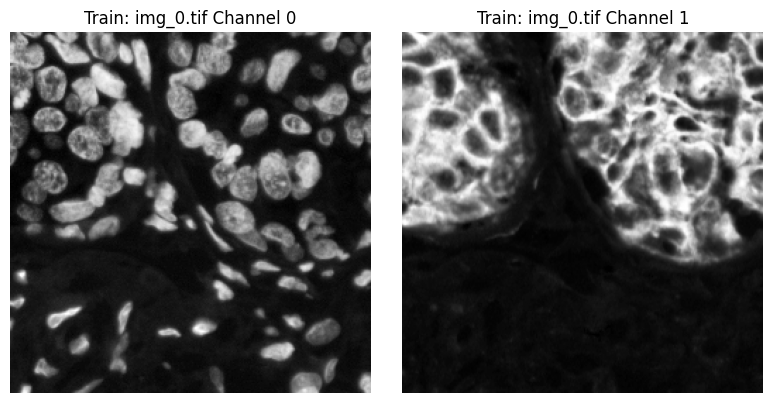

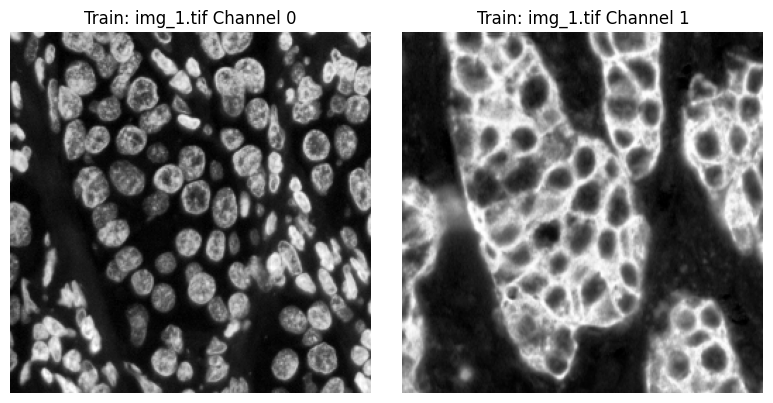

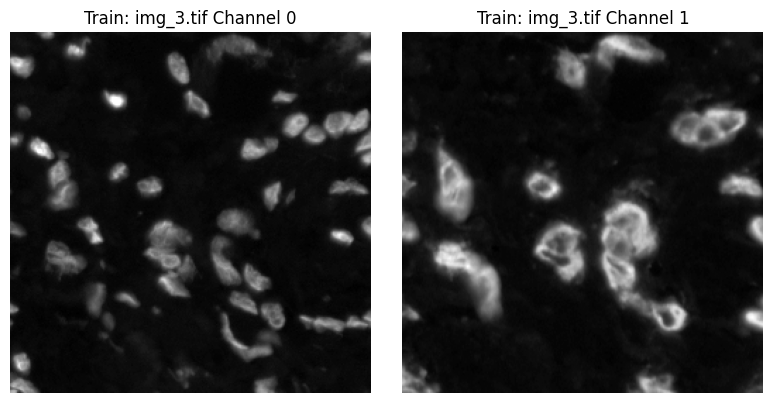

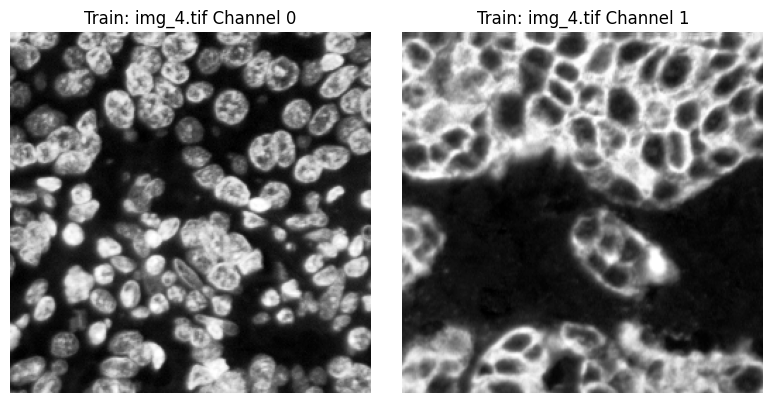

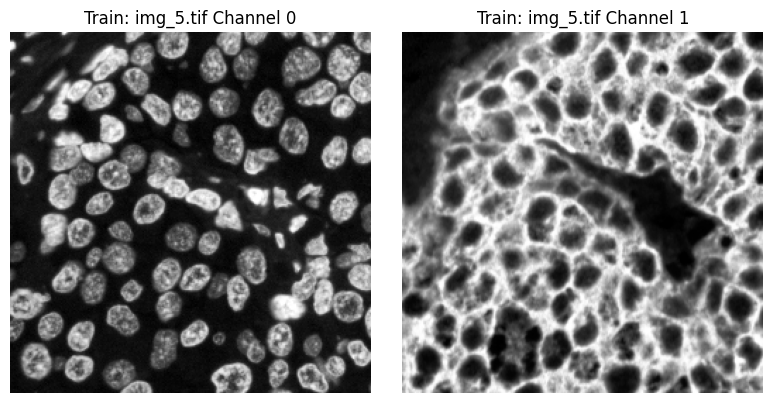

=== Testing Images ===


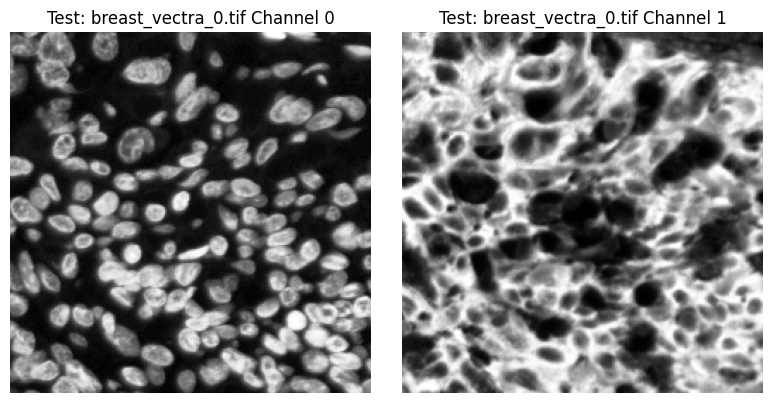

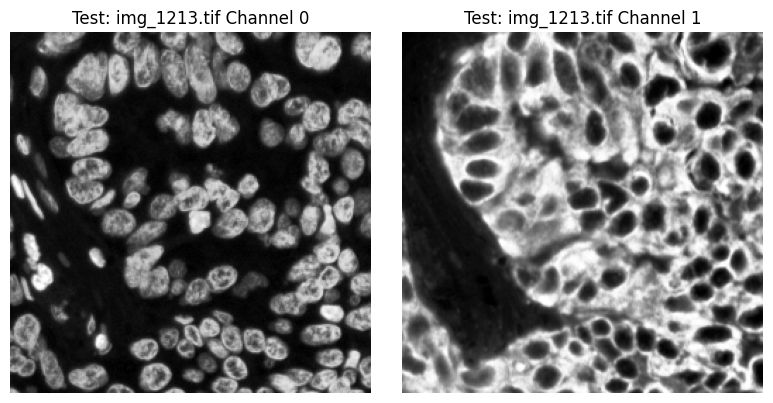

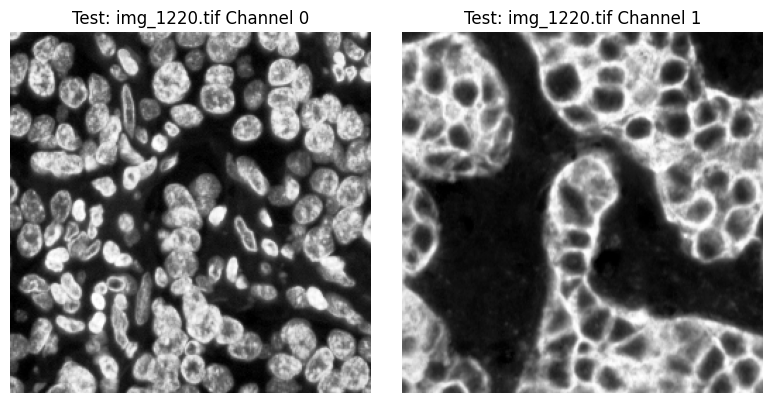

In [77]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread

def plot_image_channels(image_path, title_prefix=""):
    img = imread(image_path)
    if img.shape[0] != 2:
        print(f"Skipping {image_path}, unexpected shape: {img.shape}")
        return

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    for i in range(2):
        axes[i].imshow(img[i], cmap='gray')
        axes[i].set_title(f"{title_prefix} Channel {i}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


# Plot training images
print("=== Training Images ===")
for fname in sorted(os.listdir(train_dir)):
    if fname.endswith(".tif"):
        plot_image_channels(os.path.join(train_dir, fname), title_prefix=f"Train: {fname}")

# Plot testing images
print("=== Testing Images ===")
for fname in sorted(os.listdir(test_dir)):
    if fname.endswith(".tif"):
        plot_image_channels(os.path.join(test_dir, fname), title_prefix=f"Test: {fname}")


In [89]:
import os
import numpy as np

def inspect_seg_files(directory):
    for filename in os.listdir(directory):
        if filename.endswith("_seg.npy"):
            path = os.path.join(directory, filename)
            try:
                seg = np.load(path, allow_pickle=True)
                print(f"{filename}: type={type(seg)}, shape={getattr(seg, 'shape', 'n/a')}, dtype={getattr(seg, 'dtype', 'n/a')}")
                if isinstance(seg, np.ndarray):
                    print(f"  min={np.min(seg)}, max={np.max(seg)}")
                elif isinstance(seg, dict):
                    print(f"  keys: {list(seg.keys())}")
            except Exception as e:
                print(f"{filename}: FAILED to load - {e}")

print("=== Training masks ===")
inspect_seg_files("human_in_the_loop/train")

print("\n=== Testing masks ===")
inspect_seg_files("human_in_the_loop/test")



Streaming output truncated to the last 5000 lines.
       87, 87, 88, 88, 88, 88, 88, 88, 89, 89, 89, 89, 89, 90, 90, 90, 90,
       91, 91, 91]), array([229, 228, 228, 228, 227, 227, 227, 227, 227, 226, 226, 226, 226,
       226, 225, 225, 225, 225, 226, 226, 226, 226, 227, 227, 228, 229,
       230, 230, 231, 232, 233, 234, 235, 236, 236, 237, 238, 238, 239,
       240, 240, 241, 241, 241, 241, 241, 241, 241, 240, 240, 239, 238,
       238, 237, 236, 235, 234, 233, 232, 231, 230, 229, 230, 231, 232,
       233, 234, 235, 236, 237, 228, 229, 230, 231, 232, 233, 234, 235,
       236, 237, 238, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
       238, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
       240, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
       239, 240, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
       238, 239, 240, 241, 227, 228, 229, 230, 231, 232, 233, 234, 235,
       236, 237, 238, 239, 240, 241, 227, 228, 229, 230, 231,

In [90]:
import os
import numpy as np

def inspect_seg_objects(directory):
    for filename in os.listdir(directory):
        if filename.endswith("_seg.npy"):
            path = os.path.join(directory, filename)
            try:
                seg_obj = np.load(path, allow_pickle=True).item()  # likely a dict
                print(f"{filename}: type={type(seg_obj)} keys={list(seg_obj.keys())}")

                # Try to get the label mask array if present
                if "masks" in seg_obj:
                    masks = seg_obj["masks"]
                    print(f"  masks shape: {masks.shape}, dtype: {masks.dtype}, min: {masks.min()}, max: {masks.max()}")
                else:
                    # fallback: try just print the type of the loaded object
                    print(f"  Object does not contain 'masks' key. Full keys: {list(seg_obj.keys())}")

            except Exception as e:
                print(f"{filename}: FAILED to load - {e}")

print("=== Training segmentation objects ===")
inspect_seg_objects("human_in_the_loop/train")

print("\n=== Testing segmentation objects ===")
inspect_seg_objects("human_in_the_loop/test")


=== Training segmentation objects ===
img_1_seg.npy: type=<class 'dict'> keys=['outlines', 'colors', 'masks', 'chan_choose', 'img', 'filename', 'flows', 'ismanual', 'manual_changes', 'model_path']
  masks shape: (256, 256), dtype: uint16, min: 0, max: 174
img_3_seg.npy: type=<class 'dict'> keys=['outlines', 'colors', 'masks', 'chan_choose', 'img', 'filename', 'flows', 'ismanual', 'manual_changes', 'model_path']
  masks shape: (256, 256), dtype: uint16, min: 0, max: 69
img_5_seg.npy: type=<class 'dict'> keys=['outlines', 'colors', 'masks', 'chan_choose', 'img', 'filename', 'flows', 'ismanual', 'manual_changes', 'model_path']
  masks shape: (256, 256), dtype: uint16, min: 0, max: 127
img_4_seg.npy: type=<class 'dict'> keys=['outlines', 'colors', 'masks', 'chan_choose', 'img', 'filename', 'flows', 'ismanual', 'manual_changes', 'model_path']
  masks shape: (256, 256), dtype: uint16, min: 0, max: 171
img_0_seg.npy: type=<class 'dict'> keys=['outlines', 'colors', 'masks', 'chan_choose', 'img

## Train new model

In [82]:
from cellpose import train

model_name = "2-cell_model"

# default training params
n_epochs = 20
learning_rate = 1e-5
weight_decay = 0.1
batch_size = 1

# get files
output = io.load_train_test_data(train_dir, test_dir, mask_filter=masks_ext)
train_data, train_labels, _, test_data, test_labels, _ = output
# (not passing test data into function to speed up training)

new_model_path, train_losses, test_losses = train.train_seg(model.net,
                                                            train_data=train_data,
                                                            train_labels=train_labels,
                                                            test_data=test_data,
                                                            test_labels=test_labels,
                                                            normalize=True,
                                                            batch_size=batch_size,
                                                            n_epochs=n_epochs,
                                                            learning_rate=learning_rate,
                                                            weight_decay=weight_decay,
                                                            min_train_masks=2,
                                                            nimg_per_epoch=max(2, len(train_data)), # can change this
                                                            model_name=model_name)


2025-07-23 22:53:35,843 [INFO] not all flows are present, running flow generation for all images
2025-07-23 22:53:35,860 [INFO] 5 / 5 images in human_in_the_loop/train/ folder have labels
2025-07-23 22:53:35,862 [INFO] not all flows are present, running flow generation for all images
2025-07-23 22:53:35,873 [INFO] 3 / 3 images in human_in_the_loop/test/ folder have labels
2025-07-23 22:53:35,874 [INFO] computing flows for labels


100%|██████████| 5/5 [00:00<00:00, 18.43it/s]

2025-07-23 22:53:36,151 [INFO] computing flows for labels



100%|██████████| 3/3 [00:00<00:00, 22.12it/s]

2025-07-23 22:53:36,295 [INFO] >>> computing diameters



100%|██████████| 3/3 [00:00<00:00, 1397.95it/s]

2025-07-23 22:53:36,307 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': True, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}
2025-07-23 22:53:36,334 [INFO] >>> n_epochs=20, n_train=5, n_test=3
2025-07-23 22:53:36,335 [INFO] >>> AdamW, learning_rate=0.00001, weight_decay=0.10000
2025-07-23 22:53:36,338 [INFO] >>> saving model to /content/models/2-cell_model


2025-07-23 22:53:41,854 [INFO] 0, train_loss=1.1305, test_loss=2.0365, LR=0.000000, time 5.52s
2025-07-23 22:54:06,014 [INFO] 5, train_loss=1.2033, test_loss=2.0312, LR=0.000006, time 29.68s
2025-07-23 22:54:30,639 [INFO] 10, train_loss=1.1791, test_loss=2.0130, LR=0.000010, time 54.30s
2025-07-23 22:55:14,105 [INFO] saving network parameters to /content/models/2-cell_model


## Evaluate on test data (optional)

If you have test data, check performance

In [83]:
img = test_data[0]
print(f"Shape: {img.shape}, dtype: {img.dtype}, min: {img.min()}, max: {img.max()}")


Shape: (2, 256, 256), dtype: float32, min: 0.0, max: 1.0


In [84]:
for i, img in enumerate(train_data):
    print(f"Train {i}: shape={img.shape}, min={img.min()}, max={img.max()}")

for i, img in enumerate(test_data):
    print(f"Test {i}: shape={img.shape}, min={img.min()}, max={img.max()}")


Train 0: shape=(2, 256, 256), min=0.0011616531992331147, max=1.0
Train 1: shape=(2, 256, 256), min=0.0, max=0.9993891716003418
Train 2: shape=(2, 256, 256), min=6.155361188575625e-05, max=0.9937002062797546
Train 3: shape=(2, 256, 256), min=0.003606797894462943, max=0.9994497895240784
Train 4: shape=(2, 256, 256), min=0.0003051944077014923, max=1.0
Test 0: shape=(2, 256, 256), min=0.0, max=1.0
Test 1: shape=(2, 256, 256), min=0.0, max=1.0
Test 2: shape=(2, 256, 256), min=0.0, max=1.0


In [85]:
from cellpose import metrics

model = models.CellposeModel(gpu=True,
                             pretrained_model="/content/models/2-cell_model")

# run model on test images
masks = model.eval(test_data, batch_size=32)[0]

# check performance using ground truth labels
ap = metrics.average_precision(test_labels, masks)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')


2025-07-23 22:55:37,043 [INFO] ** TORCH CUDA version installed and working. **
2025-07-23 22:55:37,044 [INFO] >>>> using GPU (CUDA)
2025-07-23 22:55:39,546 [INFO] >>>> loading model /content/models/2-cell_model
2025-07-23 22:55:44,469 [INFO] 100%|##########| 3/3 [00:04<00:00,  1.51s/it]

>>> average precision at iou threshold 0.5 = 0.742


plot masks

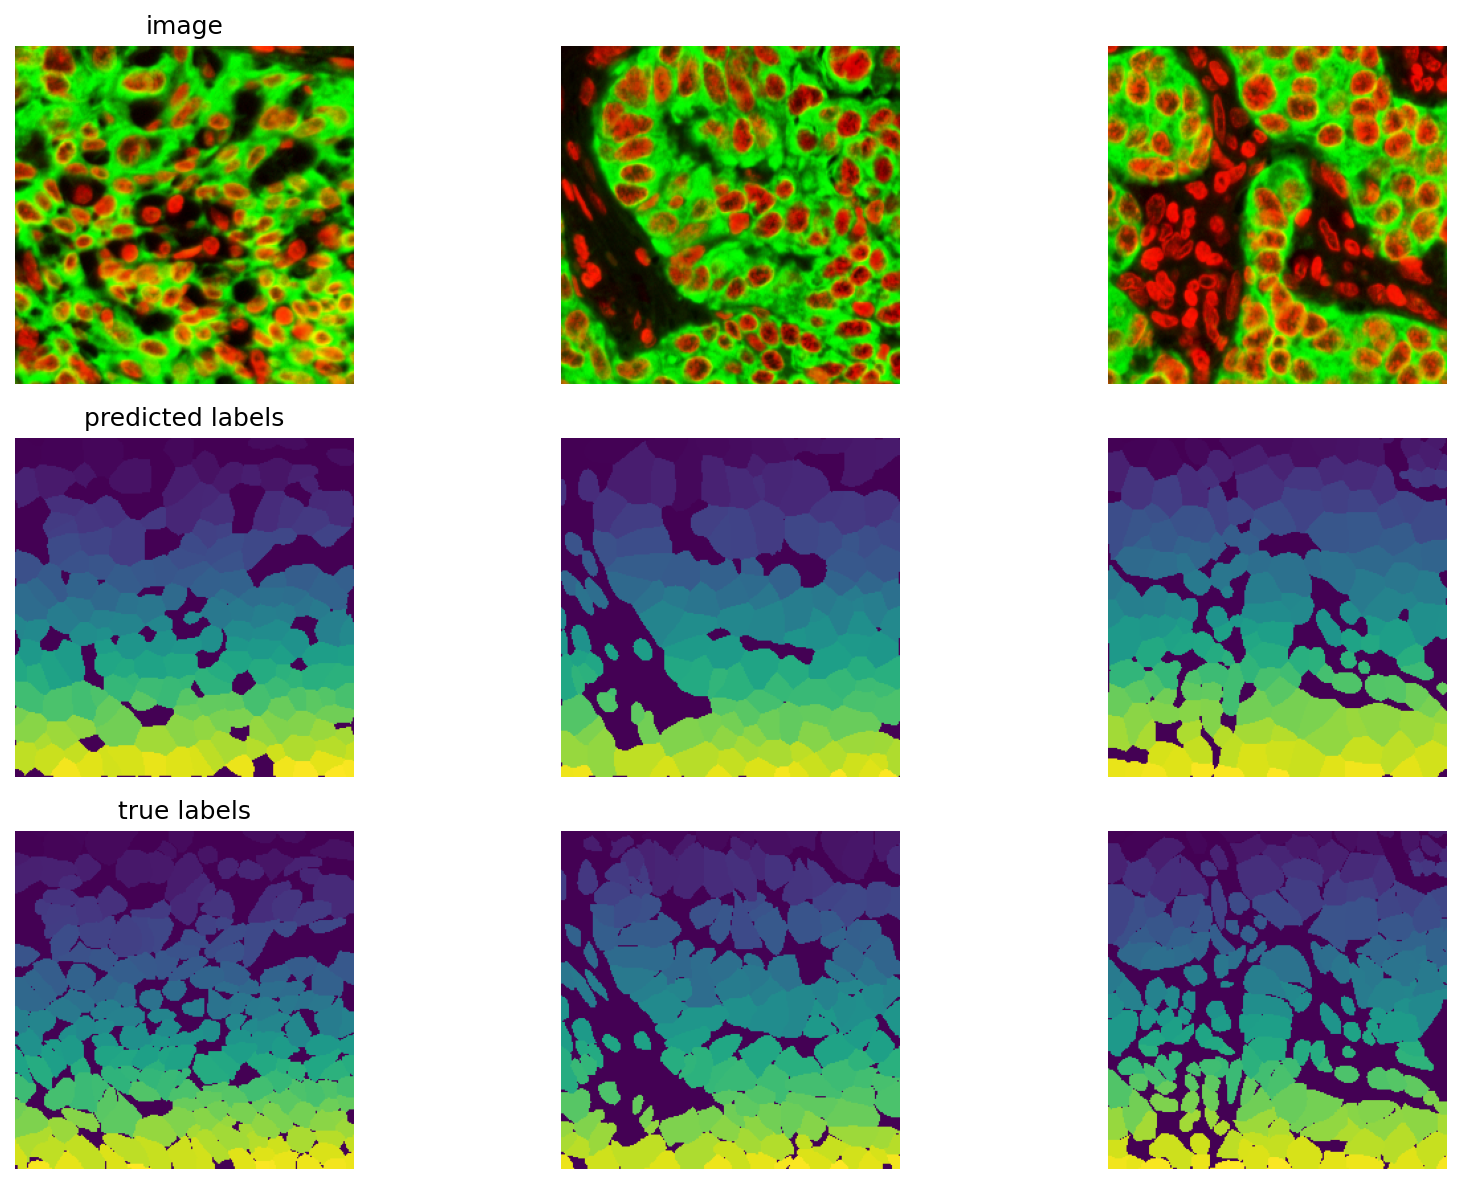

In [87]:
plt.figure(figsize=(12,8), dpi=150)
for k,im in enumerate(test_data):
    img = im.copy()
    plt.subplot(3,len(test_data), k+1)
    img = np.vstack((img, np.zeros_like(img)[:1]))
    img = img.transpose(1,2,0)
    plt.imshow(img)
    plt.axis('off')
    if k==0:
        plt.title('image')

    plt.subplot(3,len(test_data), len(test_data) + k+1)
    plt.imshow(masks[k])
    plt.axis('off')
    if k==0:
        plt.title('predicted labels')

    plt.subplot(3,len(test_data), 2*len(test_data) + k+1)
    plt.imshow(test_labels[k])
    plt.axis('off')
    if k==0:
        plt.title('true labels')
plt.tight_layout()

TypeError: Invalid shape (256, 256, 2) for image data

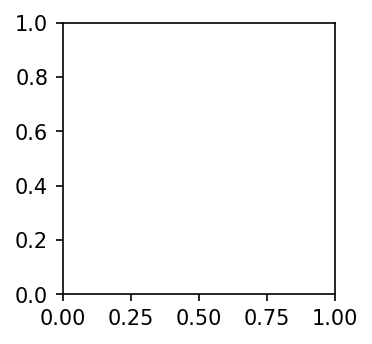

In [86]:
plt.figure(figsize=(12, 8), dpi=150)

for k, im in enumerate(test_data):
    img = im.copy()

    # First row: raw image
    plt.subplot(3, len(test_data), k + 1)

    # Handle grayscale vs RGB or shape (1, H, W)
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    elif img.ndim == 3 and img.shape[0] == 1:
        plt.imshow(img[0], cmap='gray')
    elif img.ndim == 3 and img.shape[0] in [2, 3]:
        plt.imshow(img.transpose(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
    else:
        raise ValueError(f"Unexpected image shape: {img.shape}")

    plt.axis('off')
    if k == 0:
        plt.title('image')

    # Second row: predicted masks
    plt.subplot(3, len(test_data), len(test_data) + k + 1)
    plt.imshow(masks[k], cmap='nipy_spectral')
    plt.axis('off')
    if k == 0:
        plt.title('predicted labels')

    # Third row: ground truth masks
    plt.subplot(3, len(test_data), 2 * len(test_data) + k + 1)
    plt.imshow(test_labels[k], cmap='nipy_spectral')
    plt.axis('off')
    if k == 0:
        plt.title('true labels')

plt.tight_layout()
plt.show()
